In [1]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed.` %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)


requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4
[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


In [2]:
import pandas as pd
import numpy as np 

df = pd.read_csv('./data/flight_data.csv')

# 1. Exploratory Data Analysis

## Preliminary Information

In [3]:
# get the shape of dataset
rows, cols = df.shape
print(f"The shape of the dataset is as follows: {rows} rows, {cols} cols.")

print(df.info())

The shape of the dataset is as follows: 998866 rows, 18 cols.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998866 entries, 0 to 998865
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   from_airport_code                998866 non-null  object 
 1   from_country                     998866 non-null  object 
 2   dest_airport_code                998866 non-null  object 
 3   dest_country                     998866 non-null  object 
 4   aircraft_type                    984952 non-null  object 
 5   airline_number                   998866 non-null  object 
 6   airline_name                     998866 non-null  object 
 7   flight_number                    998866 non-null  object 
 8   departure_time                   998866 non-null  object 
 9   arrival_time                     998866 non-null  object 
 10  duration                         998866 non-null  int64  
 11  sto

## Information on Target Variable
The chosen target variable is the CO2 emissions of a given flight, and it's a continuous variable since it covers a wide spectrum of values. 

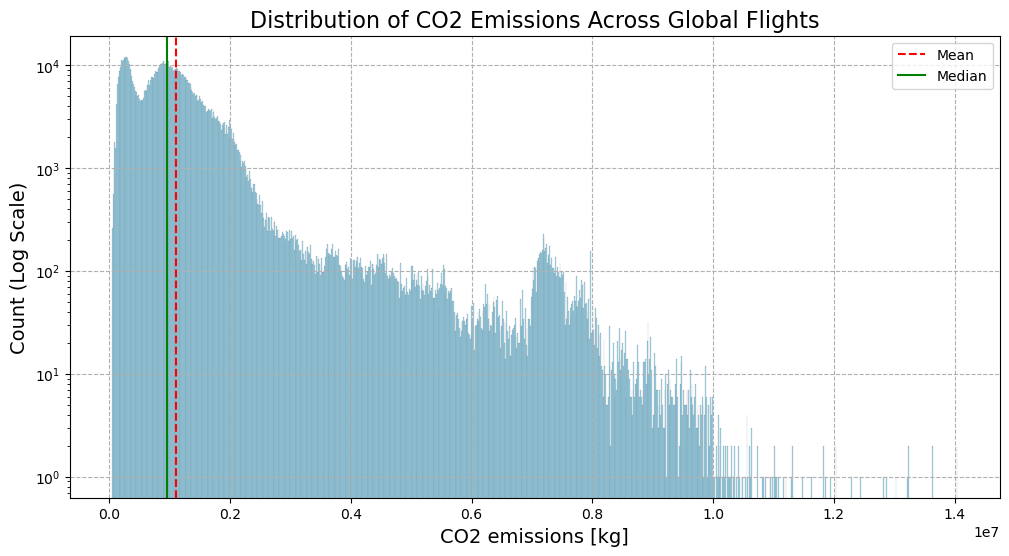

For the target variable, the mean is 1111010.421550144 & the median is 956000.0


In [4]:
# Visualize target variable
import matplotlib.pyplot as plt
import seaborn as sns

mean_val = df['co2_emissions'].mean()
median_val = df['co2_emissions'].median()

plt.figure(figsize=(12, 6))
count = int(np.sqrt(df.shape[0]))
sns.histplot(df['co2_emissions'], bins=count, color='skyblue', kde=False)

plt.yscale('log')
plt.axvline(mean_val, color='r', linestyle='--')
plt.axvline(median_val, color='g', linestyle='-')
plt.grid(True, linestyle='--')
plt.xlabel('CO2 emissions [kg]', fontsize=14)
plt.ylabel('Count (Log Scale)', fontsize=14)
plt.title('Distribution of CO2 Emissions Across Global Flights', fontsize=16)
plt.legend({'Mean': mean_val, 'Median': median_val})
plt.savefig("co2_distribution.png", dpi=300)
plt.show()

print(f"For the target variable, the mean is {mean_val} & the median is {median_val}")

## More Visualizations & Insights
First, I'm going to look at which variables correlate the most with the target variable by using a correlation matrix. 

In [5]:
# Correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()
corr_with_target = corr_matrix['co2_emissions'].sort_values(key=abs, ascending=False)
corr_with_target = corr_with_target.drop('co2_emissions')
corr_with_target = corr_with_target.drop('avg_co2_emission_for_this_route')
print(corr_with_target.head(5))

price       0.724647
duration    0.492424
stops       0.377681
Name: co2_emissions, dtype: float64


## Continuous Variables

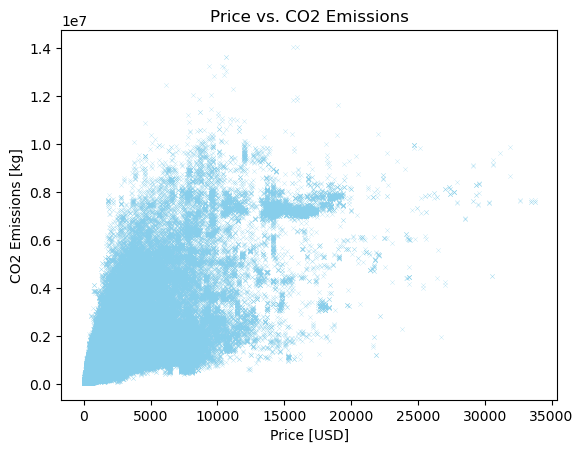

In [6]:
# Price VS CO2 Emissions
plt.figure()
sns.scatterplot(data=df, x='price', y='co2_emissions', marker='x', color='skyblue', alpha=0.6, s=10)
plt.title('Price vs. CO2 Emissions')
plt.xlabel('Price [USD]')
plt.ylabel('CO2 Emissions [kg]')
plt.savefig("price_vs_co2_emissions.png", dpi=300)
plt.show()

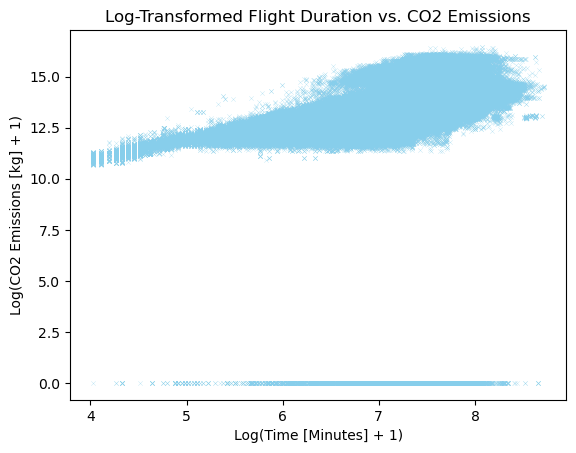

In [7]:
# Duration VS CO2 Emissions
log_duration = np.log1p(df['duration'])
log_co2_emissions = np.log1p(df['co2_emissions'].fillna(0))

plt.figure()
sns.scatterplot(x=log_duration, y=log_co2_emissions, marker='x', color='skyblue', alpha=0.6, s=10)
plt.title('Log-Transformed Flight Duration vs. CO2 Emissions')
plt.xlabel('Log(Time [Minutes] + 1)')
plt.ylabel('Log(CO2 Emissions [kg] + 1)')
plt.show()

## Ordinal Variables

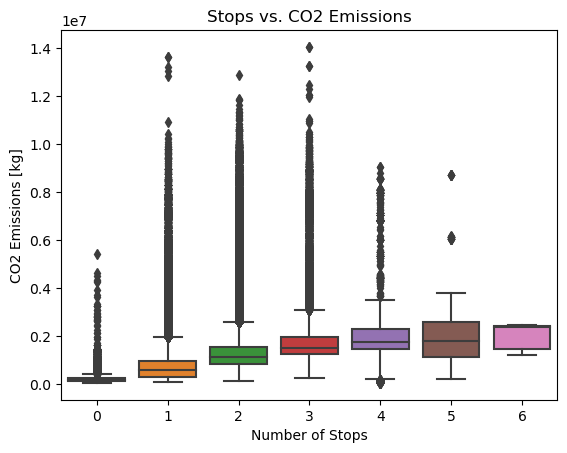

In [8]:
# Stops VS CO2 Emissions
plt.figure()
sns.boxplot(data=df, x='stops', y='co2_emissions')

plt.title('Stops vs. CO2 Emissions')
plt.xlabel('Number of Stops')
plt.ylabel('CO2 Emissions [kg]')
plt.savefig("stops_vs_co2_emissions.png", dpi=300)
plt.show()

The box plot above suggests that flights with more stops will tend to have higher emissions. This also is confirmed with the correlation coefficient that we've seen above, of approximately 0.378. The heights of the boxes show that flights with 3+ stops have a wider range of CO2 emissions compared to flights with fewer stops - could be attributed to distance, passenger load, or the type of aircraft. Furthermore, the median line shifts upwards as the number of stops increases, which confirms the hypothesis that more stops generally correlate with higher emissions. The points outside the whiskers, the outliers, are especially abundant, which could point to the fact that this variable alone isn't enough to explain the variation in emissions. There are most likely other variables (that I mentioned) that contribute to the emissions.

## Categorical Variables

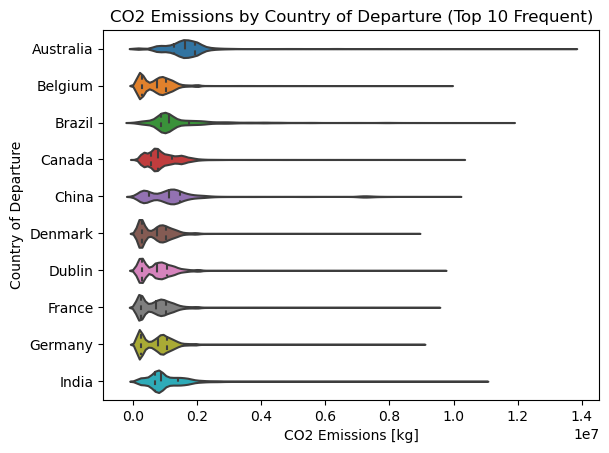

In [9]:
# from_country VS CO2_emissions
country_counts = df['from_country'].value_counts()
top_10 = country_counts.nlargest(10).index
filtered_df = df[df['from_country'].isin(top_10)]

plt.figure()
sns.violinplot(x='co2_emissions', y='from_country', data=filtered_df, inner='quartile')
plt.title('CO2 Emissions by Country of Departure (Top 10 Frequent)')
plt.xlabel('CO2 Emissions [kg]')
plt.ylabel('Country of Departure')
plt.show()

Since the width of the violin indicates the density of data points at that level, we can see that Australia has the highest CO2 emissions among all the countries that appear the most frequently in the dataset. The long "tail" for the violins observed could be due to multiple-leg flights, longer flights, or usage of aircraft with higher emissions.

**NOTE!** Dropping rows is a part of EDA, and I have decided that solely looking at single-leg flights would be the optimal approach. I am going to drop the rows that contain multi-leg flights from my dataset. This is because it is not possible to obtain precise per-leg information based on aircrafts. As can be seen from the entries above, the flights in the dataset involve multiple legs operated by different aircraft types, so it would be difficult to specifically isolate a specific aircraft's contribution to CO2 emissions when it comes to these rows.

In [10]:
# Clean dataset 
def is_single_aircraft_type(cell):
    return isinstance(cell, str) and '|' not in cell and cell != ''
single_aircraft_mask = df['aircraft_type'].apply(is_single_aircraft_type)

df_single_aircraft = df[single_aircraft_mask].copy()

# drop rows where target variable is missing
df_single_aircraft_clean = df_single_aircraft.dropna(subset=['co2_emissions'])
# drop columns that are closely related to the target variable / irrelevant
columns_to_drop = ['co2_percentage', 'avg_co2_emission_for_this_route', 'stops', 'currency', 'scan_date', 'airline_number', 'airline_name', 'flight_number']
df_single_aircraft_clean = df_single_aircraft_clean.drop(columns=columns_to_drop)

# reassign the variable df to our new filtered df_single_aircraft for simplicity
df = df_single_aircraft_clean.copy()

print(df.shape)
# df.to_csv("new_dataset.csv", index=False)
# Provide a link to download the CSV file directly from the notebook
# from IPython.display import FileLink
# FileLink('new_dataset.csv')

(16819, 10)


## Analyzing Missing Values

In [11]:
missing_value_placeholders = ['N/A', 'NA', 'Not Available', '', 'Unknown']
df.replace(missing_value_placeholders, np.nan, inplace=True)
missing_values = df.isnull().sum().sum()
print(f'There are {missing_values} missing values in the dataset')


# Iterating through each column in the DataFrame
for column in df.columns:
    missing_count = df[column].isnull().sum()
    all_value_count = df.shape[0]
    fraction_missing_values = missing_count / all_value_count
    print(f"{column} has {missing_count} missing values, "
          f"which accounts for {fraction_missing_values:.2%} of the entire data.")
missing_count = df['price'].isnull().sum()

There are 847 missing values in the dataset
from_airport_code has 0 missing values, which accounts for 0.00% of the entire data.
from_country has 0 missing values, which accounts for 0.00% of the entire data.
dest_airport_code has 0 missing values, which accounts for 0.00% of the entire data.
dest_country has 0 missing values, which accounts for 0.00% of the entire data.
aircraft_type has 0 missing values, which accounts for 0.00% of the entire data.
departure_time has 0 missing values, which accounts for 0.00% of the entire data.
arrival_time has 0 missing values, which accounts for 0.00% of the entire data.
duration has 0 missing values, which accounts for 0.00% of the entire data.
price has 847 missing values, which accounts for 5.04% of the entire data.
co2_emissions has 0 missing values, which accounts for 0.00% of the entire data.


# 2. Splitting

## Consideration of iid/non -iid dataset
First we need to consider whether this dataset is iid. I believe this dataset is non-iid because it has time-based attributes like departure_time -- flights that are closer in time might be more similar to each other. Similarity can also be geographical, since flights leaving from the same airports might share characteristics. Most obviously, I expect groups like price and duration to be correlated. I will be splitting on `price` for the following reasons:
1. From correlation matrix, there’s an underlying relationship between the price of a flight and CO2 emissions. Longer flights are often more expensive and produce more CO2
2. We want representative splits and by stratifying on price, we can ensure that each data subset contains a representative range of prices so that the model generalizes well
3. We also want to avoid bias - don’t want random split (eg. high priced flights could end up in training set). We don’t want nonrepresentative samples in each subset.

In [12]:
# Splitting (on price)
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer

X = df.drop(columns=['co2_emissions'])
y = df['co2_emissions']

# first, need to convert timestamps to float
def convert_timestamps(df, timestamp_columns):
    '''
    converts each timestamp to a total number of minutes since midnight
    '''
    for col in timestamp_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d %H:%M:%S')
            converted_col_name = col + '_converted'
            df[converted_col_name] = df[col].dt.hour * 60 + df[col].dt.minute
            df[col] = df[converted_col_name]
            df.drop(columns=[converted_col_name], inplace=True)
    return df

timestamp_columns = ['departure_time', 'arrival_time']

X = convert_timestamps(X.copy(), timestamp_columns)
# Need to fix the missing values in price so we can split on it
# but we have to split before preprocessing
# therefore we do a temporary imputation just for creating price bins
temp_price = df['price'].fillna(df['price'].median())

price_bins = pd.qcut(temp_price, q=4, duplicates='drop')

X_train, X_other, y_train, y_other = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=price_bins
)

X_CV, X_test, y_CV, y_test = train_test_split(
    X_other, y_other, test_size=0.5, random_state=42
)

print(len(X_train), len(X_CV), len(X_test))

13455 1682 1682


# 3. Preprocessing

In [13]:
# Now, impute missing values separately for each dataset
imputer = IterativeImputer(random_state=42)
X_train['price'] = imputer.fit_transform(X_train[['price']])
X_CV['price'] = imputer.transform(X_CV[['price']])
X_test['price'] = imputer.transform(X_test[['price']])

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin


# collect the various features - notice we don't have ordinal features anymore
cat_ftrs = ['from_airport_code', 'from_country', 'dest_airport_code', 'dest_country', 'aircraft_type']
num_ftrs = ['departure_time', 'arrival_time', 'duration', 'price']


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)
    ])

# 4. Choosing Evaluation Metric

## Implementing Regression Baselines
We want to calculate the baseline metrics (R^2, MSE, RMSE, MAE) for the models later, so we first have to establish simple baseline predictions. I will use the mean of `y_train` as a baseline prediction for each instance in `y_test`.

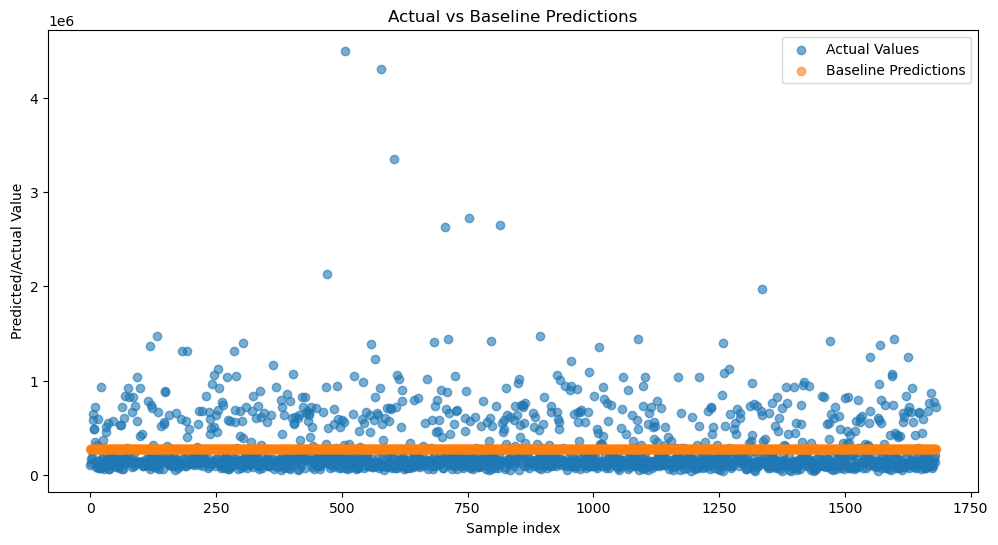

Baseline R-squared: -0.002
Baseline MSE: 110534038418.096
Baseline RMSE: 332466.597
Baseline MAE: 211768.459


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
baseline_predictions = np.full(shape=y_test.shape, fill_value=y_train.mean())

baseline_r2 = r2_score(y_test, baseline_predictions)
baseline_mse = mean_squared_error(y_test, baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test, baseline_predictions)

plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_test)), baseline_predictions, label='Baseline Predictions', alpha=0.6)
plt.title('Actual vs Baseline Predictions')
plt.xlabel('Sample index')
plt.ylabel('Predicted/Actual Value')
plt.legend()
plt.savefig("baseline_evaluation.png", dpi=300)
plt.show()

print(f"Baseline R-squared: {baseline_r2:.3f}")
print(f"Baseline MSE: {baseline_mse:.3f}")
print(f"Baseline RMSE: {baseline_rmse:.3f}")
print(f"Baseline MAE: {baseline_mae:.3f}")

# 5. Choosing ML Techniques & 6. Cross-Validation

## Starting with simple model like LinearRegression

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
import numpy as np

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])  # Placeholder regressor

# Create the parameter grid
param_grid = [{
    'regressor': [LinearRegression()],
}, {
    'regressor': [Lasso(max_iter=10000, tol=0.1, random_state=42)],
    'regressor__alpha': [10, 15, 20, 30, 50, 100]  
}, {
    'regressor': [Ridge(max_iter=10000, tol=0.05, random_state=42)],
    'regressor__alpha': [10, 15, 20, 30, 50, 100]  
}]


# Apply GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters and score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best R^2 score: {grid_search.best_score_}')

# Predict and evaluate using the best model
y_pred = grid_search.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred):.3f}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
print(f'R^2 Score: {r2_score(y_test, y_pred):.3f}')


Fitting 5 folds for each of 13 candidates, totalling 65 fits
Best parameters: {'regressor': LinearRegression()}
Best R^2 score: 0.8132574354703668
MSE: 23526551019.627
RMSE: 153383.673
R^2 Score: 0.787


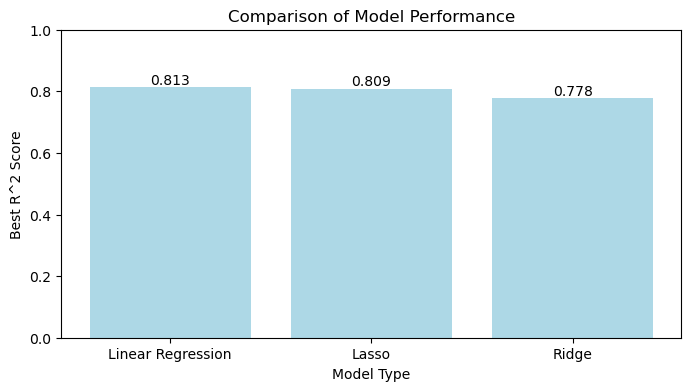

In [17]:
# Extract results from grid search
results = pd.DataFrame(grid_search.cv_results_)
lin_reg_results = results[results['param_regressor'].apply(lambda x: isinstance(x, LinearRegression))]
lasso_results = results[results['param_regressor'].apply(lambda x: isinstance(x, Lasso))]
ridge_results = results[results['param_regressor'].apply(lambda x: isinstance(x, Ridge))]

# Model Comparison
model_scores = [
    lin_reg_results['mean_test_score'].max(),
    lasso_results['mean_test_score'].max(),
    ridge_results['mean_test_score'].max()
]
model_names = ['Linear Regression', 'Lasso', 'Ridge']

plt.figure(figsize=(8, 4))
bars = plt.bar(model_names, model_scores, color='lightblue')
plt.bar(model_names, model_scores, color='lightblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), 
             va='bottom', ha='center', fontsize=10)
plt.xlabel('Model Type')
plt.ylabel('Best R^2 Score')
plt.title('Comparison of Model Performance')
plt.ylim([0, 1])  # Assuming R^2 score range
plt.savefig("lin_model_performance.png", dpi=300)
plt.show()

## RandomForestRegressor

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(random_state=42))])

rf_param_grid = {
    'regressor__n_estimators': [50, 55, 60],
    'regressor__max_depth': [15, 20, 25]
}

rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=4, scoring='r2')
rf_grid_search.fit(X_train, y_train)

y_pred = rf_grid_search.predict(X_test)
print(f'rf Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}')
print(f'rf rmse: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
# print(f'rf R^2 Score: {r2_score(y_test, y_pred):.3f}')

# print(f'rf Best model: {grid_search.best_model_}')
print(f'rf Best parameters: {rf_grid_search.best_params_}')
print(f'rf Best R^2 score: {rf_grid_search.best_score_}')

rf Mean Squared Error: 8578311286.428
rf rmse: 92619.173
rf R^2 Score: 0.922
rf Best parameters: {'regressor__max_depth': 20, 'regressor__n_estimators': 60}
rf Best R^2 score: 0.9166482175672835


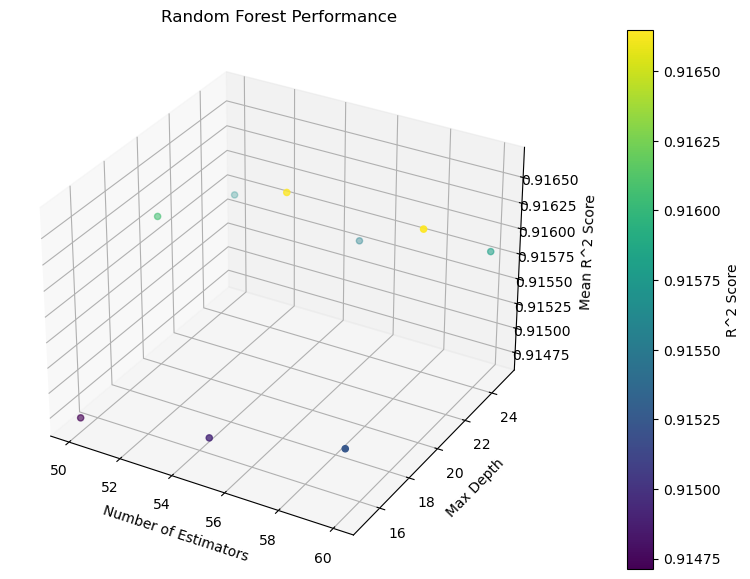

In [20]:
from mpl_toolkits.mplot3d import Axes3D


# Convert the grid search results to a DataFrame
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

# Extract necessary data
n_estimators = rf_results['param_regressor__n_estimators']
max_depth = rf_results['param_regressor__max_depth']
scores = rf_results['mean_test_score']

# Creating a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D data
scat = ax.scatter(n_estimators, max_depth, scores, c=scores, cmap='viridis')

# Adding labels and title
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('Max Depth')
ax.set_zlabel('Mean R^2 Score', labelpad=10)
plt.title('Random Forest Performance')

# Adding a color bar
cbar = fig.colorbar(scat, ax=ax, pad=0.1)
cbar.set_label('R^2 Score')

plt.savefig("rf_performance.png", dpi=300)
plt.show()

## XGBoost Regression

In [21]:
from xgboost import XGBRegressor

xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', XGBRegressor(random_state=42))])

xgb_param_grid = {
    'regressor__n_estimators': [125, 150, 175, 200, 225],
    'regressor__max_depth': [4, 5, 6],
    'regressor__learning_rate': [0.15, 0.2, 0.25],
}

xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='r2', verbose=1)
xgb_grid_search.fit(X_train, y_train)

print(f'xgb Best parameters: {xgb_grid_search.best_params_}')
print(f'xgb Best R^2 score: {xgb_grid_search.best_score_}')

y_pred = xgb_grid_search.predict(X_test)
print(f'xgb Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}')
print(f'xgb RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
print(f'xgb R^2 Score: {r2_score(y_test, y_pred):.3f}')

Fitting 5 folds for each of 45 candidates, totalling 225 fits
xgb Best parameters: {'regressor__learning_rate': 0.2, 'regressor__max_depth': 5, 'regressor__n_estimators': 225}
xgb Best R^2 score: 0.9362021109686518
xgb Mean Squared Error: 9212646944.105
xgb RMSE: 95982.535
xgb R^2 Score: 0.917


## SVM Regressor

In [22]:
from sklearn.svm import SVR

svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', SVR())])

svm_param_grid = {
    'regressor__C': [170, 180, 190, 200, 210],
    'regressor__gamma': ['scale'],
    'regressor__kernel': ['linear'],
}

svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='r2', verbose=1)
svm_grid_search.fit(X_train, y_train)

print(f'svm Best parameters: {svm_grid_search.best_params_}')
print(f'svm Best R^2 score: {svm_grid_search.best_score_}')

y_pred = svm_grid_search.predict(X_test)
print(f'svm Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}')
print(f'svm RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
# print(f'svm R^2 Score: {r2_score(y_test, y_pred):.3f}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
svm Best parameters: {'regressor__C': 190, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}
svm Best R^2 score: 0.7278975864362065
svm Mean Squared Error: 36413240778.779
svm RMSE: 190822.537


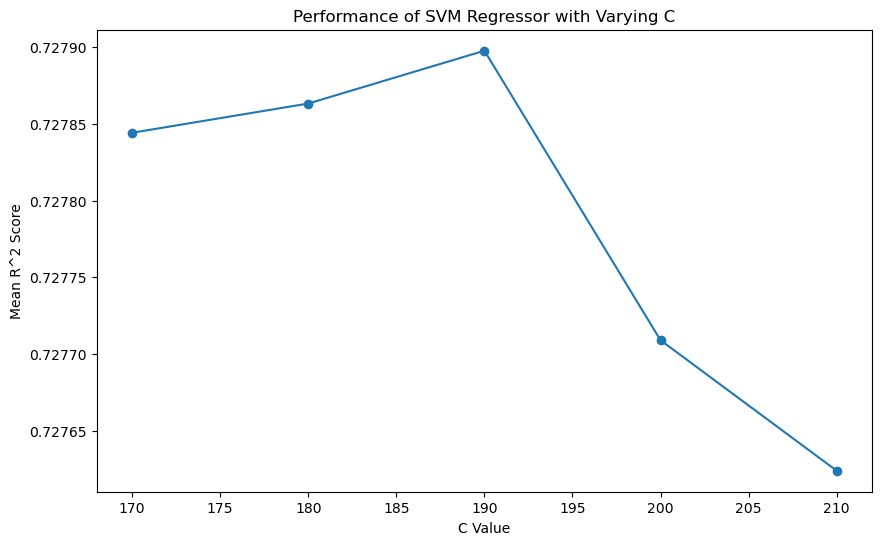

In [23]:
# Convert the grid search results to a DataFrame
results = pd.DataFrame(svm_grid_search.cv_results_)

# Extracting the C values and corresponding mean test scores
C_values = results['param_regressor__C']
scores = results['mean_test_score']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(C_values, scores, marker='o')
plt.xlabel('C Value')
plt.ylabel('Mean R^2 Score')
plt.title('Performance of SVM Regressor with Varying C')
plt.savefig("svm_performance.png", dpi=300)
plt.show()

# 7. Interpreting Results